In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy import signal as sig
from sklearn.decomposition import FastICA
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from scipy.stats import entropy
from scipy.stats import skew, kurtosis
from sklearn.model_selection import learning_curve
import os
import h5py

In [5]:
# Define paths to the MAT files
edf_mat_path = "../data/EDF_RawData.mat" # rows correspond to time samples and columns correspond to channels
xml_mat_path = "../data/XML_RawData.mat"


In [10]:
from data.edf_data_import import (
    describe_edf_mat_structure,
    extract_eeg_signal,
    extract_all_eeg_signals,
    compute_signal_features,
    compute_psd,
    )
describe_edf_mat_structure(edf_mat_path)

Keys in MAT file:
 - #refs#
 - allData

Structure of 'allData':
  Attribute MATLAB_class: b'struct'
  Attribute MATLAB_fields: [array([b'f', b'i', b'l', b'e', b'N', b'a', b'm', b'e'], dtype='|S1')
 array([b'h', b'd', b'r'], dtype='|S1')
 array([b'r', b'e', b'c', b'o', b'r', b'd'], dtype='|S1')]
  Field: fileName
  Field: hdr
  Field: record

Decoded file names from 'allData':
  1: R 1 . e d f 
  2: R 1 0 . e d f 
  3: R 2 . e d f 
  4: R 3 . e d f 
  5: R 4 . e d f 
  6: R 5 . e d f 
  7: R 6 . e d f 
  8: R 7 . e d f 
  9: R 8 . e d f 
  10: R 9 . e d f 
'bigMatrix' not found in the MAT file.


In [9]:
# Set the channel index for EEG (adjust as needed—e.g., channel 0 is assumed to be EEG)
eeg_channel_idx = 0

# Extract EEG signals from all EDF files
all_eeg_signals = extract_all_eeg_signals(edf_mat_path, channel=eeg_channel_idx)
print(f"Number of EDF files processed: {len(all_eeg_signals)}")

# Verify the shape of each extracted EEG signal
for idx, signal in enumerate(all_eeg_signals):
    print(f"EDF file {idx+1} signal shape: {signal.shape}")

Number of EDF files processed: 10
EDF file 1 signal shape: (4065000,)
EDF file 2 signal shape: (4065000,)
EDF file 3 signal shape: (4046250,)
EDF file 4 signal shape: (3933750,)
EDF file 5 signal shape: (3281250,)
EDF file 6 signal shape: (4065000,)
EDF file 7 signal shape: (4065000,)
EDF file 8 signal shape: (3446250,)
EDF file 9 signal shape: (3596250,)
EDF file 10 signal shape: (4072500,)


Number of EDF files processed: 10
EDF file 1 signal shape: (4065000,)
EDF file 2 signal shape: (4065000,)
EDF file 3 signal shape: (4046250,)
EDF file 4 signal shape: (3933750,)
EDF file 5 signal shape: (3281250,)
EDF file 6 signal shape: (4065000,)
EDF file 7 signal shape: (4065000,)
EDF file 8 signal shape: (3446250,)
EDF file 9 signal shape: (3596250,)
EDF file 10 signal shape: (4072500,)


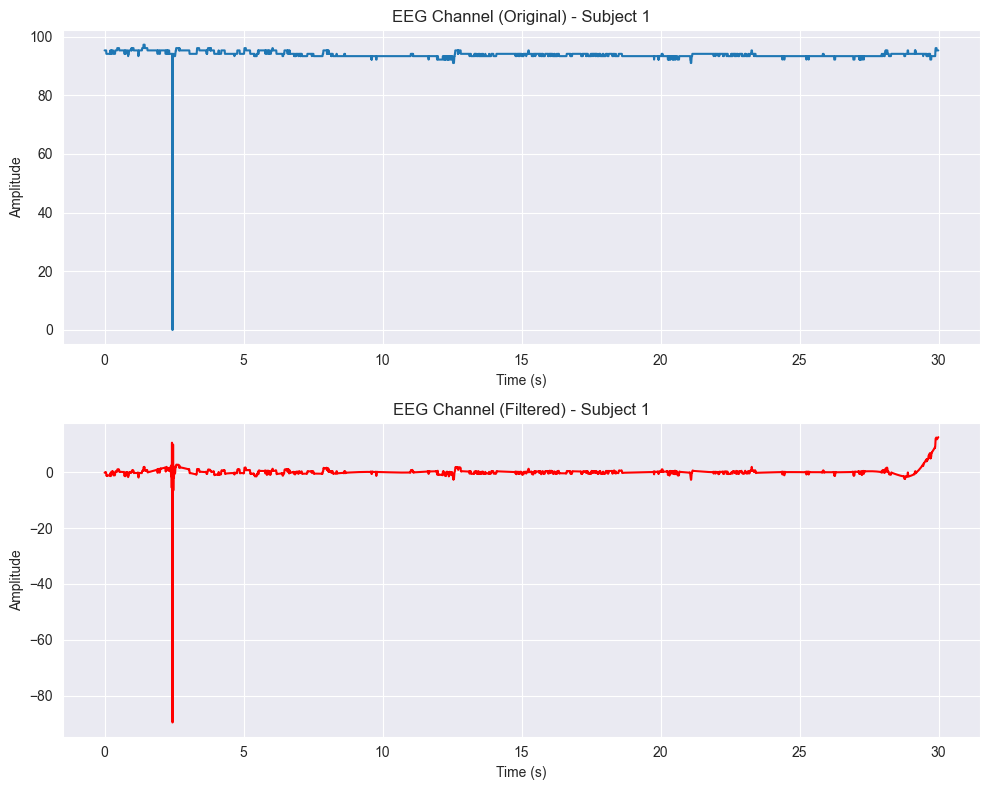

EEG Signal Features for All EDF Files:
       mean   variance       rms  peak_to_peak  zero_crossings  \
0  0.635573  58.852684  7.697833     98.045319               0   
1  0.774338  74.707297  8.677955     99.217212               0   
2  0.745668  69.886851  8.393025     99.217212               0   
3  0.761866  72.415477  8.543765     99.217212               0   
4  0.765756  73.105161  8.584378     99.217212               0   
5  0.760500  71.834660  8.509584     99.217212               0   
6  0.761192  72.030855  8.521166     98.045319               0   
7  0.758827  72.827450  8.567571     99.998474               0   
8  0.768386  73.572287  8.611777     99.217212               0   
9  0.671379  61.432532  7.866593     98.045319               0   

   hjorth_activity  hjorth_mobility  hjorth_complexity  file_index  
0        58.852684         0.041293          34.286007           0  
1        74.707297         0.036339          38.912563           1  
2        69.886851         

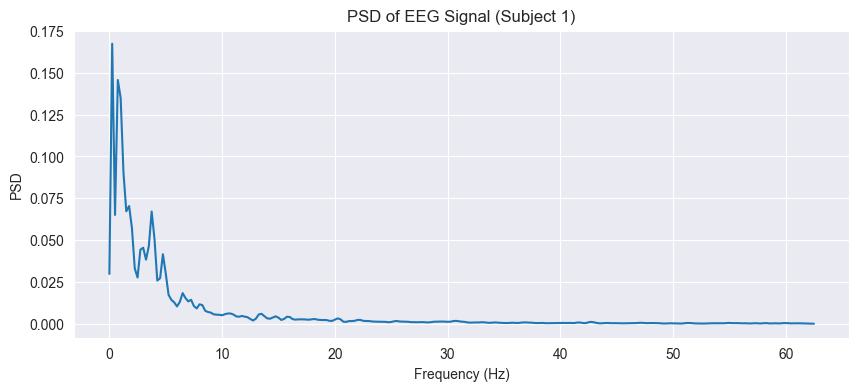

In [15]:
from scipy.signal import butter, filtfilt

# ============================
# 1. Output Directory Setup
# ============================
output_dir = os.path.join(os.getcwd(), '@Output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

def get_output_path(filename):
    return os.path.join(output_dir, filename)

# ============================
# 3. Extract EEG Signals for All Patients
# ============================
# Set the channel index for EEG.
# 'eeg_channel_idx' corresponding to the EEG channel
eeg_channel_idx = 0

# Extract all EEG signals (each is a 1D numpy array).
all_eeg_signals = extract_all_eeg_signals(edf_mat_path, channel=eeg_channel_idx)
print(f"Number of EDF files processed: {len(all_eeg_signals)}")
for idx, signal in enumerate(all_eeg_signals):
    print(f"EDF file {idx+1} signal shape: {signal.shape}")

# ============================
# 4. Build a Combined EEG Data Array
# ============================
# If you want to assemble a big EEG matrix (each column corresponding to a patient),
# you may need to account for different signal lengths.
# For simplicity, we create a list of arrays. # TODO
all_eeg_data = all_eeg_signals  # List of 1D arrays (one per patient)

# Optionally, if you wish to work with a common length, you could truncate or pad the signals.
# Here, we simply proceed with the list.

# ============================
# 5. EEG Preprocessing and Filtering
# ============================
fs_eeg = 125  # Sampling frequency in Hz
epoch_length = 30  # epoch length in seconds (if needed for further segmentation)

# For demonstration, let’s process the EEG signal from the first subject.
example_eeg = all_eeg_signals[0]

# Define bandpass filter parameters: 0.5 Hz to 45 Hz
nyquist = fs_eeg / 2
low_cutoff = 0.5 / nyquist
high_cutoff = 45 / nyquist

# Design a 4th-order Butterworth filter
b, a = butter(4, [low_cutoff, high_cutoff], btype='band')

# Apply the filter using filtfilt (zero-phase filtering)
filtered_eeg = filtfilt(b, a, example_eeg)

# Keep the original signal for comparison
original_eeg = example_eeg.copy()

# ============================
# 6. Plot EEG Channels: Original vs Filtered
# ============================
# Plot a 30-second segment (30 s * 125 Hz = 3750 samples)
segment_samples = fs_eeg * epoch_length
t = np.arange(segment_samples) / fs_eeg

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(t, original_eeg[:segment_samples])
axs[0].set_title("EEG Channel (Original) - Subject 1")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

axs[1].plot(t, filtered_eeg[:segment_samples], 'r-')
axs[1].set_title("EEG Channel (Filtered) - Subject 1")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

# ============================
# 7. Compute and Aggregate EEG Features Across Patients
# ============================
# Loop over all subjects to compute time-domain features from the raw EEG signals.
all_features = []
for i, signal in enumerate(all_eeg_signals):
    feat = compute_signal_features(signal)
    feat['file_index'] = i
    all_features.append(feat)

df_features = pd.DataFrame(all_features)
print("EEG Signal Features for All EDF Files:")
print(df_features)

# ============================
# 8. Example Frequency Domain Analysis (for the first subject)
# ============================
f, Pxx = compute_psd(example_eeg, fs=fs_eeg)

# Define frequency bands:
delta_idx = (f >= 0.5) & (f < 4)
theta_idx = (f >= 4) & (f < 8)
alpha_idx = (f >= 8) & (f < 12)
beta_idx  = (f >= 12) & (f < 30)
gamma_idx = (f >= 30) & (f < 45)

delta_power = np.trapezoid(Pxx[delta_idx], f[delta_idx])
theta_power = np.trapezoid(Pxx[theta_idx], f[theta_idx])
alpha_power = np.trapezoid(Pxx[alpha_idx], f[alpha_idx])
beta_power  = np.trapezoid(Pxx[beta_idx], f[beta_idx])
gamma_power = np.trapezoid(Pxx[gamma_idx], f[gamma_idx])
total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power

print("Relative Delta Power:", delta_power/total_power)
print("Relative Theta Power:", theta_power/total_power)
print("Relative Alpha Power:", alpha_power/total_power)
print("Relative Beta Power:", beta_power/total_power)
print("Relative Gamma Power:", gamma_power/total_power)

plt.figure(figsize=(10,4))
plt.plot(f, Pxx)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD of EEG Signal (Subject 1)")
plt.grid(True)
plt.show()

# ICA (Independent Component Analysis) for EEG artifact removal:

### 1. Data Preparation
- The code combines multiple biosignals into a single matrix:
  - 2 EEG channels (already filtered)
  - 2 EOG (electrooculogram) channels for eye movements
  - 1 EMG (electromyogram) channel for muscle activity
  - 1 ECG (electrocardiogram) channel for heart activity
- The data is transposed to match FastICA's expected format `[n_samples, n_features]`

### 2. ICA Application
- FastICA is applied to extract 6 independent components
- Two key matrices are produced:
  - `S`: The independent components (source signals)
  - `A`: The mixing matrix (how components combine to form original signals)

### 3. Visualization of Components
- Plots all 6 ICA components for visual inspection
- Shows 5 epochs of data for each component
- Creates a mixing matrix visualization showing how each original channel contributes to the ICA components
- Both plots are saved as PNG files

### 4. Artifact Component Identification
- Calculates correlations between:
  - Each ICA component
  - Each artifact channel (EOG, EMG, ECG)
- Creates a correlation matrix visualization
- Uses a correlation threshold (0.6) to identify components related to artifacts
- Separately tracks components related to:
  - Eye movements (EOG)
  - Muscle activity (EMG)
  - Heart activity (ECG)
- Prints which components are associated with each type of artifact

### 5. Signal Reconstruction
- Creates cleaned signal by:
  1. Making a copy of the ICA components
  2. Zeroing out components identified as artifacts
  3. Reconstructing the signal using the mixing matrix
- Extracts only the cleaned EEG channels from the reconstruction

### 6. Final Visualization
- Creates comparison plots showing:
  - Original filtered EEG
  - ICA-cleaned EEG
- Shows 5 epochs of data for each channel
- Saves the comparison plot as a PNG file

This is a standard artifact removal pipeline for EEG data using ICA. The process identifies components that represent artifacts (eye movements, muscle activity, heart beats) and removes them while preserving the underlying brain activity signals.

The correlation threshold (0.6) is a tunable parameter - lower values will remove more components but might lose some genuine brain signals, while higher values are more conservative but might leave some artifacts in the data.


In [ ]:
# Apply ICA to the filtered eeg_data
# Combine all channels for ICA
all_channels = np.vstack([
    eeg_data,      # 2 EEG channels (already filtered)
    eog_data,      # 2 EOG channels 
    emg_data,      # 1 EMG channel
    ecg_data       # 1 ECG channel
])

# Transpose for ICA (ICA expects [n_samples, n_features])
X = all_channels.T

# Apply FastICA to extract 6 components
ica = FastICA(n_components=6, random_state=42)
S = ica.fit_transform(X)  # S contains the independent components
A = ica.mixing_  # A is the mixing matrix

# Get the independent components (transposed back to [n_components, n_samples])
components = S.T

# Plot the 6 ICA components
plt.figure(figsize=(12, 10))
sample_length = fs_eeg * epoch_length * 5  # Show 5 epochs

for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(components[i, :sample_length])
    plt.title(f'ICA Component {i+1}')
    plt.tight_layout()

plt.savefig(get_output_path('ica_components.png'))
plt.show()

# Plot contribution of each original channel to each ICA component (mixing matrix)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(A), aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('ICA Components')
plt.ylabel('Channels (EEG1, EEG2, EOGL, EOGR, EMG, ECG)')
plt.title('Mixing Matrix')
plt.tight_layout()
plt.savefig(get_output_path('mixing_matrix.png'))
plt.show()

# Filter out components that are correlated with the EOG, EMG and ECG channels
# Find the components that are most correlated with the EOG, EMG and ECG channels

# Calculate correlation between each component and each artifact channel
artifact_channels = np.vstack([eog_data, emg_data, ecg_data])
correlation_matrix = np.zeros((artifact_channels.shape[0], components.shape[0]))

for i in range(artifact_channels.shape[0]):
    for j in range(components.shape[0]):
        correlation = np.abs(np.corrcoef(artifact_channels[i, :], components[j, :])[0, 1])
        correlation_matrix[i, j] = correlation

# Plot correlation matrix
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Correlation Coefficient')
plt.xlabel('ICA Components')
plt.ylabel('Artifact Channels (EOGL, EOGR, EMG, ECG)')
plt.title('Correlation between ICA Components and Artifact Channels')
channel_names = ['EOGL', 'EOGR', 'EMG', 'ECG']
plt.yticks(np.arange(len(channel_names)), channel_names)
plt.xticks(np.arange(components.shape[0]), [f'Comp {i+1}' for i in range(components.shape[0])])
plt.tight_layout()
plt.savefig(get_output_path('correlation_matrix.png'))
plt.show()

# Identify components to remove (high correlation with artifact channels)
# Correlation threshold for component removal - adjust based on data quality
# Lower values (e.g., 0.2) will remove more components but may lose useful signal
# Higher values (e.g., 0.4) will be more conservative but may retain more artifacts
correlation_threshold = 0.6  # Adjust this value based on your dataset

# Create separate sets for different artifact types
eog_components = set()
emg_components = set()
ecg_components = set()
components_to_remove = set()

for i in range(correlation_matrix.shape[0]):
    # Find components with correlation above threshold
    high_corr_idx = np.where(correlation_matrix[i, :] > correlation_threshold)[0]
    if len(high_corr_idx) > 0:
        if i < 2:  # EOG channels (first two artifact channels)
            print(f"Channel {channel_names[i]} is highly correlated with components: {[idx+1 for idx in high_corr_idx]}")
            eog_components.update(high_corr_idx)
        elif i == 2:  # EMG channel
            print(f"Channel {channel_names[i]} is highly correlated with components: {[idx+1 for idx in high_corr_idx]}")
            emg_components.update(high_corr_idx)
        elif i == 3:  # ECG channel
            print(f"Channel {channel_names[i]} is highly correlated with components: {[idx+1 for idx in high_corr_idx]}")
            ecg_components.update(high_corr_idx)

# Add all identified components to the removal set
# You can comment out any line below to keep certain artifact types if needed
components_to_remove.update(eog_components)  # Eye movement artifacts
components_to_remove.update(emg_components)  # Muscle artifacts
components_to_remove.update(ecg_components)  # Heart artifacts

components_to_remove = list(components_to_remove)
components_to_keep = [i for i in range(components.shape[0]) if i not in components_to_remove]

print(f"EOG-related components: {[idx+1 for idx in eog_components]}")
print(f"EMG-related components: {[idx+1 for idx in emg_components]}")
print(f"ECG-related components: {[idx+1 for idx in ecg_components]}")
print(f"Components to remove: {[idx+1 for idx in components_to_remove]}")
print(f"Components to keep: {[idx+1 for idx in components_to_keep]}")

# Reconstruct cleaned signal
# Zero out the artifact components and reconstruct
S_clean = S.copy()
for idx in components_to_remove:
    S_clean[:, idx] = 0

X_clean = np.dot(S_clean, ica.mixing_.T) + ica.mean_

# Reshape back to original format [channels, samples]
cleaned_channels = X_clean.T
cleaned_eeg = cleaned_channels[:2, :]  # Extract only EEG channels

# Plot original filtered EEG vs cleaned EEG
plt.figure(figsize=(12, 8))

for i in range(eeg_data.shape[0]):
    plt.subplot(2, 1, i+1)
    plt.plot(eeg_data[i, :fs_eeg*epoch_length*5], 'b-', label='Filtered')
    plt.plot(cleaned_eeg[i, :fs_eeg*epoch_length*5], 'r-', label='ICA Cleaned')
    plt.title(f'EEG Channel {i+1}: Filtered vs ICA Cleaned')
    plt.legend()

plt.tight_layout()
plt.savefig(get_output_path('cleaned_eeg.png'))
plt.show()


In [ ]:

# perform a DWT on the cleaned eeg_data to extract frequency bands

# Define wavelet and decomposition level
wavelet = 'db4'
level = 6  # Decomposition level

# Frequency bands for DWT decomposition with fs=125Hz
# Note: These are approximate ranges due to the nature of wavelet transforms
# Actual passbands are not as sharp as in FIR/IIR filters
#
# At sampling rate of 125Hz:
# - Nyquist frequency: 62.5 Hz
# - DWT Level 1 detail coefficients (cD1): ~31.25-62.5 Hz (gamma)
# - DWT Level 2 detail coefficients (cD2): ~15.625-31.25 Hz (beta)
# - DWT Level 3 detail coefficients (cD3): ~7.8125-15.625 Hz (alpha/spindles)
# - DWT Level 4 detail coefficients (cD4): ~3.90625-7.8125 Hz (theta)
# - DWT Level 5 detail coefficients (cD5): ~1.953125-3.90625 Hz (delta)
# - DWT Level 6 detail coefficients (cD6): ~0.9765625-1.953125 Hz (slow delta)
# - DWT Level 6 approximation coefficients (cA6): ~0-0.9765625 Hz (very slow oscillations)

# Perform DWT on cleaned EEG data (using channel 1)
coeffs = pywt.wavedec(cleaned_eeg[0, :], wavelet, level=level)

# Extract coefficients (1 approximation + 6 details)
cA6, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

# Create zero arrays with the same shape as the coefficients
zero_cA6 = np.zeros_like(cA6)
zero_cD6 = np.zeros_like(cD6)
zero_cD5 = np.zeros_like(cD5)
zero_cD4 = np.zeros_like(cD4)
zero_cD3 = np.zeros_like(cD3)
zero_cD2 = np.zeros_like(cD2)
zero_cD1 = np.zeros_like(cD1)

# Reconstruct each frequency band
# For slow delta band (0-1 Hz): Use cA6
coeffs_slow_delta = [cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, zero_cD2, zero_cD1]
slow_delta_band = pywt.waverec(coeffs_slow_delta, wavelet)[:len(cleaned_eeg[0, :])]

# For delta band (1-4 Hz): Use cD6 (1-2 Hz) and cD5 (2-4 Hz)
coeffs_delta = [zero_cA6, cD6, cD5, zero_cD4, zero_cD3, zero_cD2, zero_cD1]
delta_band = pywt.waverec(coeffs_delta, wavelet)[:len(cleaned_eeg[0, :])]

# For theta band (4-8 Hz): Use cD4
coeffs_theta = [zero_cA6, zero_cD6, zero_cD5, cD4, zero_cD3, zero_cD2, zero_cD1]
theta_band = pywt.waverec(coeffs_theta, wavelet)[:len(cleaned_eeg[0, :])]

# For alpha/spindle band (8-16 Hz): Use cD3
coeffs_alpha = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, cD3, zero_cD2, zero_cD1]
alpha_spindle_band = pywt.waverec(coeffs_alpha, wavelet)[:len(cleaned_eeg[0, :])]

# For beta band (16-32 Hz): Use cD2
coeffs_beta = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, cD2, zero_cD1]
beta_band = pywt.waverec(coeffs_beta, wavelet)[:len(cleaned_eeg[0, :])]

# For gamma band (32-62.5 Hz): Use cD1
coeffs_gamma = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, zero_cD2, cD1]
gamma_band = pywt.waverec(coeffs_gamma, wavelet)[:len(cleaned_eeg[0, :])]

# Plot different frequency bands
band_names = ['Slow Delta (0-1 Hz)', 'Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha+Spindles (8-16 Hz)', 'Beta (16-32 Hz)', 'Gamma (32-62.5 Hz)']
bands = [slow_delta_band, delta_band, theta_band, alpha_spindle_band, beta_band, gamma_band]

plt.figure(figsize=(15, 14))

# Plot original signal
plt.subplot(7, 1, 1)
plt.plot(cleaned_eeg[0, :fs_eeg*epoch_length*3])
plt.title('Cleaned EEG (Channel 1)')

# Plot each frequency band
for i, (band, name) in enumerate(zip(bands, band_names)):
    plt.subplot(7, 1, i+2)
    plt.plot(band[:fs_eeg*epoch_length*3])
    plt.title(name)

plt.tight_layout()
plt.savefig(get_output_path('eeg_bands.png'))
plt.show()

# Sleep spindle detection in EEG data:

### 1. Sleep Spindle Background
Sleep spindles are distinct patterns in EEG signals that:
- Occur in the 10-15 Hz frequency range
- Typically last between 0.5-2 seconds
- Are important markers of stage 2 sleep

### 2. Detection Parameters Setup
The code establishes several key parameters:
- Uses pre-filtered data in the alpha/spindle band (10-15 Hz)
- Sets threshold factors:
  - Lower threshold factor: 1.0
  - Upper threshold factor: 5.0
- Defines duration constraints:
  - Minimum duration: 0.4 seconds
  - Maximum duration: 2.0 seconds

### 3. Signal Processing Steps
1. **Envelope Calculation**
   - Uses Hilbert transform to compute the signal envelope
   - The envelope represents the amplitude modulation of the signal

2. **Threshold Calculation**
   - Computes mean of the envelope
   - Sets two thresholds:
     - Lower threshold = mean × 1.0
     - Upper threshold = mean × 5.0

3. **Spindle Detection Algorithm**
   - Creates a mask where signal is between thresholds
   - Scans through the mask to find continuous segments
   - Validates segments based on duration criteria
   - Stores valid spindles as (start, end, duration) tuples

### 4. Visualization (Three-Panel Plot)
1. **Top Panel**
   - Shows the filtered signal in the spindle band (10-15 Hz)
   - Displays 30 seconds of data

2. **Middle Panel**
   - Shows the signal envelope
   - Displays both upper and lower thresholds as dashed lines

3. **Bottom Panel**
   - Shows the original filtered signal
   - Highlights detected spindles with yellow transparent overlays
   - Includes time axis in seconds

### 5. Results Output
- Prints total number of detected spindles
- For the first 10 spindles, displays:
  - Start time (in seconds)
  - Duration (in seconds)

The method looks for sustained periods where the signal envelope falls within specific amplitude bounds and meets duration criteria.


In [ ]:
# Detect sleep spindles (10-15 Hz in alpha_spindle_band)
# Spindles typically have frequencies between 10-15 Hz and last 0.5-2 seconds

# Use the alpha_spindle_band directly instead of applying additional filtering
spindle_band = alpha_spindle_band

# Calculate the signal envelope
spindle_envelope = np.abs(sig.hilbert(spindle_band))

threshold_factor_lower = 1.0
threshold_factor_upper = 5.0
min_duration = 0.4
max_duration = 2.0

# Define a threshold based on the mean envelope
mean_envelope = np.mean(spindle_envelope)
lower_threshold = threshold_factor_lower * mean_envelope
upper_threshold = threshold_factor_upper * mean_envelope

# 3) Create a mask that is True only where envelope is between lower and upper thresholds
valid_mask = (spindle_envelope >= lower_threshold) & (spindle_envelope <= upper_threshold)

# 4) Scan the mask to detect contiguous segments that qualify as spindles
spindles = []
i = 0
n_samples = len(spindle_band)

while i < n_samples:
    if valid_mask[i]:
        start = i
        # Move forward while we remain within valid_mask == True
        while i < n_samples and valid_mask[i]:
            i += 1
        end = i
        duration = (end - start) / fs_eeg

        # 5) Check duration constraints
        if min_duration <= duration <= max_duration:
            spindles.append((start, end, duration))
    else:
        i += 1

# Plot results
plt.figure(figsize=(15, 10))

# Create time array for x-axis
t = np.arange(len(spindle_band)) / fs_eeg

# Plot a subset of the data for better visualization
display_duration = 30  # seconds
display_samples = min(display_duration * fs_eeg, len(spindle_band))

# Plot original signal
plt.subplot(3, 1, 1)
plt.plot(t[:display_samples], spindle_band[:display_samples])
plt.title('Spindle Band (10-15 Hz)')

# Plot spindle band and envelope
plt.subplot(3, 1, 2)
plt.plot(t[:display_samples], spindle_envelope[:display_samples])
plt.axhline(y=lower_threshold, color='r', linestyle='--', label=f'Lower Threshold ({lower_threshold:.2f})')
plt.axhline(y=upper_threshold, color='g', linestyle='--', label=f'Upper Threshold ({upper_threshold:.2f})')
plt.legend()
plt.title('Spindle Envelope with Thresholds')

# Highlight detected spindles
plt.subplot(3, 1, 3)
plt.plot(t[:display_samples], spindle_band[:display_samples])

# Highlight detected spindle intervals
for start, end, duration in spindles:
    if start < display_samples:  # Only highlight spindles in the displayed time window
        plt.axvspan(t[start], t[end], color='yellow', alpha=0.3)

plt.title(f'Detected Spindles (Found {len(spindles)} spindles)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Print information about detected spindles
print(f"Detected {len(spindles)} sleep spindles")
for i, (start, end, duration) in enumerate(spindles[:10]):  # Show details for first 10 spindles
    start_time = start / fs_eeg
    print(f"Spindle {i+1}: Start: {start_time:.2f}s, Duration: {duration:.2f}s")




In [ ]:
# Calculating the total psd of each band for each epoch

# Number of epochs in the entire recording
num_epochs = len(cleaned_eeg[0, :]) // (fs_eeg * epoch_length)
print(f"Total number of epochs: {num_epochs}")

# Initialize arrays to store PSD values for each band and epoch
band_names_short = ['slow_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma']
all_bands = [slow_delta_band, delta_band, theta_band, alpha_spindle_band, beta_band, gamma_band]

# Create dictionary to store band powers by epoch
band_powers = {band_name: [] for band_name in band_names_short}
epoch_timestamps = []  # Store timestamp for each epoch (in seconds)

# Calculate frequency bands' power for each epoch
for epoch_idx in range(num_epochs):
    # Calculate epoch start and end indices
    start_idx = epoch_idx * fs_eeg * epoch_length
    end_idx = (epoch_idx + 1) * fs_eeg * epoch_length
    
    # Store epoch timestamp (middle of epoch in seconds)
    epoch_time = (start_idx + (fs_eeg * epoch_length) / 2) / fs_eeg
    epoch_timestamps.append(epoch_time)
    
    # Calculate band powers for this epoch
    for band_idx, (band, band_name) in enumerate(zip(all_bands, band_names_short)):
        # Get the epoch segment for this band
        epoch_segment = band[start_idx:end_idx]
        
        # Calculate PSD using Welch's method
        f, Pxx = sig.welch(epoch_segment, fs=fs_eeg, nperseg=min(len(epoch_segment), fs_eeg*4))
        
        # Calculate total power in band (area under PSD curve)
        total_power = np.sum(Pxx)
        band_powers[band_name].append(total_power)

# Convert lists to numpy arrays for easier manipulation
for band_name in band_names_short:
    band_powers[band_name] = np.array(band_powers[band_name])
epoch_timestamps = np.array(epoch_timestamps)

# Plot band powers across epochs
plt.figure(figsize=(15, 12))

for i, band_name in enumerate(band_names_short):
    plt.subplot(len(band_names_short), 1, i+1)
    plt.plot(epoch_timestamps / 3600, band_powers[band_name])  # Convert to hours for x-axis
    plt.title(f'{band_name.capitalize()} Band Power')
    plt.xlabel('Time (hours)')
    plt.ylabel('Power')
    
plt.tight_layout()
plt.savefig(get_output_path('band_powers_by_epoch.png'))
plt.show()

# Create a stacked plot showing relative band powers
plt.figure(figsize=(15, 8))

# Calculate relative powers (normalized for each epoch)
rel_powers = np.zeros((len(band_names_short), num_epochs))
for i, band_name in enumerate(band_names_short):
    rel_powers[i, :] = band_powers[band_name]

# Normalize so total power at each epoch = 1
epoch_totals = np.sum(rel_powers, axis=0)
for i in range(len(band_names_short)):
    rel_powers[i, :] = rel_powers[i, :] / epoch_totals

# Save the band powers to a .mat file for further analysis
band_powers_output = {
    'timestamps': epoch_timestamps,
    'slow_delta': band_powers['slow_delta'],
    'delta': band_powers['delta'],
    'theta': band_powers['theta'],
    'alpha': band_powers['alpha'],
    'beta': band_powers['beta'],
    'gamma': band_powers['gamma']
}

sio.savemat(get_output_path('band_powers.mat'), band_powers_output)

In [ ]:
# Import the sleep stages from the .mat file
sleep_stages = sio.loadmat('hypnogram.mat')['stages']
print(f"Shape of sleep stages: {sleep_stages.shape}")

# Convert to 1D array if needed
if sleep_stages.ndim > 1:
    sleep_stages = sleep_stages.flatten()

# Resample sleep stages to match the number of epochs in our band powers
# Since sleep_stages have many more data points, we'll take one value per chunk
if len(sleep_stages) != num_epochs:
    print(f"Resampling sleep stages from {len(sleep_stages)} to {num_epochs}")
    resample_factor = len(sleep_stages) / num_epochs
    resampled_sleep_stages = np.zeros(num_epochs)
    
    # Resampling method options:
    # 1. 'mode' - Most frequent value (default)
    # 2. 'first' - First value in chunk
    # 3. 'middle' - Middle value in chunk
    # 4. 'last' - Last value in chunk
    resample_method = 'mode'  # Select the method here
    
    for i in range(num_epochs):
        # Calculate indices for this chunk
        start_idx = int(i * resample_factor)
        end_idx = int((i + 1) * resample_factor)
        
        # Ensure indices are within bounds
        start_idx = max(0, min(start_idx, len(sleep_stages)-1))
        end_idx = max(start_idx+1, min(end_idx, len(sleep_stages)))
        
        # Extract chunk
        chunk = sleep_stages[start_idx:end_idx]
        
        if len(chunk) > 0:
            if resample_method == 'mode':
                # Use most frequent value (mode)
                values, counts = np.unique(chunk, return_counts=True)
                resampled_sleep_stages[i] = values[np.argmax(counts)]
            elif resample_method == 'first':
                # Use first value in chunk
                resampled_sleep_stages[i] = chunk[0]
            elif resample_method == 'middle':
                # Use middle value in chunk
                resampled_sleep_stages[i] = chunk[len(chunk)//2]
            elif resample_method == 'last':
                # Use last value in chunk
                resampled_sleep_stages[i] = chunk[-1]
            else:
                # Default to mode
                values, counts = np.unique(chunk, return_counts=True)
                resampled_sleep_stages[i] = values[np.argmax(counts)]
    
    sleep_stages = resampled_sleep_stages

# Plot sleep stages. Each column corresponds to a 30 second epoch
plt.figure(figsize=(15, 4))
plt.step(epoch_timestamps / 3600, sleep_stages, where='post')
plt.yticks([0, 1, 2, 3, 4, 5], ['REM', '', 'N3', 'N2', 'N1', 'Wake'])
plt.xlabel('Time (hours)')
plt.ylabel('Sleep Stage')
plt.title('Hypnogram')
plt.grid(True, axis='y')
plt.ylim(-0.5, 5.5)
plt.savefig(get_output_path('hypnogram.png'))
plt.show()

# Create a stacked plot showing relative band powers with sleep stages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [1, 3]})

# Plot hypnogram on top subplot
ax1.step(epoch_timestamps / 3600, sleep_stages, where='post', color='black', linewidth=1.5)
ax1.set_yticks([0, 1, 2, 3, 4, 5])
ax1.set_yticklabels(['REM', '', 'N3', 'N2', 'N1', 'Wake'])
ax1.set_ylabel('Sleep Stage')
ax1.set_title('Sleep Architecture and EEG Band Powers')
ax1.grid(True, axis='y')
ax1.set_ylim(-0.5, 5.5)

# Plot stacked relative powers on bottom subplot
colors = ['darkblue', 'royalblue', 'green', 'orange', 'red', 'purple']
ax2.stackplot(epoch_timestamps / 3600, rel_powers, labels=band_names_short, colors=colors)
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Relative Power')
ax2.legend(loc='upper right')

# Ensure the x-axes are aligned
ax1.set_xlim(ax2.get_xlim())
ax1.tick_params(labelbottom=False)  # Hide x-ticks on top plot

plt.tight_layout()
plt.savefig(get_output_path('sleep_stages_with_band_powers.png'))
plt.show()

# Calculate average band powers for each sleep stage
unique_stages = np.unique(sleep_stages)
avg_powers_by_stage = {stage: {band: [] for band in band_names_short} for stage in unique_stages}

# Ensure sleep_stages array matches the number of epochs we have power data for
min_length = min(len(sleep_stages), num_epochs)

for stage in unique_stages:
    stage_indices = np.where(sleep_stages[:min_length] == stage)[0]
    for band_name in band_names_short:
        if len(stage_indices) > 0:
            avg_powers_by_stage[stage][band_name] = np.mean(band_powers[band_name][stage_indices])

# Plot average band powers by sleep stage
plt.figure(figsize=(14, 8))

# Prepare data for grouped bar chart
stage_labels = ['REM', '', 'N3', 'N2', 'N1', 'Wake']
stage_mapping = {0: 'REM', 1: '', 2: 'N3', 3: 'N2', 4: 'N1', 5: 'Wake'}
x = np.arange(len(band_names_short))
bar_width = 0.15

for i, stage in enumerate(unique_stages):
    if stage in range(len(stage_labels)):  # Ensure the stage is valid
        stage_data = [avg_powers_by_stage[stage][band] for band in band_names_short]
        offset = i - len(unique_stages)/2 + 0.5
        plt.bar(x + offset*bar_width, stage_data, bar_width, label=stage_mapping.get(stage, f'Stage {stage}'))

plt.xlabel('Frequency Band')
plt.ylabel('Average Power')
plt.title('Average Band Powers by Sleep Stage')
plt.xticks(x, [name.capitalize() for name in band_names_short])
plt.legend()
plt.tight_layout()
plt.savefig(get_output_path('avg_power_by_sleep_stage.png'))
plt.show()

# Save the average powers by sleep stage to the mat file
stage_powers = {}
for stage in unique_stages:
    if stage in range(len(stage_labels)):
        stage_name = stage_mapping.get(stage, f'stage_{stage}')
        stage_powers[stage_name] = {band: avg_powers_by_stage[stage][band] for band in band_names_short}

# Add to existing output dictionary
band_powers_output['stage_powers'] = stage_powers

# Save again with updated information
sio.savemat(get_output_path('band_powers.mat'), band_powers_output)

# EEG feature extraction and analysis:

1. Feature Organization Structure
The code organizes features into several categories:
- Absolute power (raw power in each frequency band)
- Relative power (normalized power per band)
- Power ratios (relationships between bands)
- Spectral features (complexity measures)
- Time-domain features (statistical measures)

## 2. Feature Types and Calculations

### A. Power-Based Features
1. **Absolute Power**
   - Uses pre-calculated band powers for each frequency range
   - Includes: slow delta, delta, theta, alpha, beta, gamma

2. **Relative Power**
   - Normalizes each band's power by total power
   - Helps account for overall amplitude variations

3. **Power Ratios**
   - Calculates important band relationships:
     - Slow delta/delta
     - Delta/theta
     - Theta/alpha
     - Alpha/beta
     - Delta/beta
     - Theta/beta
     - Slow delta/gamma
     - Delta/gamma

### B. Spectral Complexity Features
1. **Spectral Entropy**
   - Measures signal randomness/complexity
   - Higher values indicate more random signals

2. **Spectral Edge Frequencies**
   - SEF50 (median frequency)
   - SEF95 (95th percentile frequency)

### C. Time Domain Features
1. **Statistical Measures**
   - Variance
   - Skewness
   - Kurtosis
   - Zero-crossing rate

2. **Hjorth Parameters**
   - Activity (signal variance)
   - Mobility (mean frequency)
   - Complexity (change in frequency)

3. **Spindle Metrics**
   - Spindle density (spindles per minute)

## 3. Visualization and Analysis

### A. Sleep Stage and Spindle Plot
- Two-panel plot showing:
  - Hypnogram (sleep stages over time)
  - Spindle occurrences by sleep stage

### B. Feature Analysis Plots
1. **Delta vs. Theta Power**
   - Scatter plot colored by sleep stage

2. **Spectral Entropy**
   - Box plot across sleep stages

3. **Spindle Density**
   - Bar chart of average density per stage

4. **Delta/Beta Ratio**
   - Box plot across sleep stages


In [ ]:
# Feature extraction
print("Extracting EEG features...")

# Initialize dictionaries to store all features
features = {
    'timestamps': epoch_timestamps,
    'absolute_power': {},  # Store absolute power for each band
    'relative_power': {},  # Store relative power (band power / total power)
    'power_ratios': {},    # Store power ratios between bands
    'spectral_features': {},  # Store spectral entropy and complexity measures
    'time_domain': {}      # Store time-domain statistics
}

# 1. Absolute and Relative Powers
total_power = np.zeros(num_epochs)
for band_name in band_names_short:
    # Store absolute power (already calculated)
    features['absolute_power'][band_name] = band_powers[band_name]
    # Add to total power for relative calculations
    total_power += band_powers[band_name]

# Calculate relative power for each band
for band_name in band_names_short:
    features['relative_power'][band_name] = band_powers[band_name] / total_power

# 2. Power Ratios - Calculate ratios between bands
ratio_pairs = [
    ('slow_delta', 'delta'),    # Slow delta to delta ratio
    ('delta', 'theta'),         # Delta to theta ratio
    ('theta', 'alpha'),         # Theta to alpha ratio
    ('alpha', 'beta'),          # Alpha to beta ratio
    ('delta', 'beta'),          # Delta to beta ratio (often used in sleep studies)
    ('theta', 'beta'),          # Theta to beta ratio (attention/concentration)
    ('slow_delta', 'gamma'),    # Slow delta to gamma ratio
    ('delta', 'gamma')          # Delta to gamma ratio
]

for band1, band2 in ratio_pairs:
    ratio_name = f"{band1}_to_{band2}"
    # Avoid division by zero with small epsilon
    features['power_ratios'][ratio_name] = band_powers[band1] / (band_powers[band2] + 1e-10)

# 3. Spectral Complexity Measures

# Calculate spectral entropy for each epoch
spectral_entropy = np.zeros(num_epochs)

for epoch_idx in range(num_epochs):
    # Extract epoch data
    start_idx = epoch_idx * fs_eeg * epoch_length
    end_idx = (epoch_idx + 1) * fs_eeg * epoch_length
    epoch_data = cleaned_eeg[0, start_idx:end_idx]
    
    # Calculate PSD
    f, Pxx = sig.welch(epoch_data, fs=fs_eeg, nperseg=min(len(epoch_data), fs_eeg*4))
    
    # Normalize PSD to calculate entropy (like a probability distribution)
    Pxx_norm = Pxx / np.sum(Pxx)
    
    # Calculate entropy (higher entropy = more complex/random signal)
    spectral_entropy[epoch_idx] = entropy(Pxx_norm)

features['spectral_features']['spectral_entropy'] = spectral_entropy

# Spectral edge frequency (frequency below which X% of power resides)
# 50% (median frequency) and 95% spectral edge
spectral_edge_50 = np.zeros(num_epochs)
spectral_edge_95 = np.zeros(num_epochs)

for epoch_idx in range(num_epochs):
    start_idx = epoch_idx * fs_eeg * epoch_length
    end_idx = (epoch_idx + 1) * fs_eeg * epoch_length
    epoch_data = cleaned_eeg[0, start_idx:end_idx]
    
    # Calculate PSD
    f, Pxx = sig.welch(epoch_data, fs=fs_eeg, nperseg=min(len(epoch_data), fs_eeg*4))
    
    # Calculate cumulative sum of power
    cumsum_pxx = np.cumsum(Pxx) / np.sum(Pxx)
    
    # Find frequencies at 50% and 95% power
    idx_50 = np.argmax(cumsum_pxx >= 0.5)
    idx_95 = np.argmax(cumsum_pxx >= 0.95)
    
    spectral_edge_50[epoch_idx] = f[idx_50]
    spectral_edge_95[epoch_idx] = f[idx_95]

features['spectral_features']['spectral_edge_50'] = spectral_edge_50
features['spectral_features']['spectral_edge_95'] = spectral_edge_95

# 4. Time Domain Features
# Calculate variance, skewness, kurtosis, zero-crossings, and Hjorth parameters

variance = np.zeros(num_epochs)
skewness = np.zeros(num_epochs)
kurtosis_val = np.zeros(num_epochs)
zero_crossings = np.zeros(num_epochs)
hjorth_activity = np.zeros(num_epochs)     # variance of signal (first derivative)
hjorth_mobility = np.zeros(num_epochs)     # sqrt(variance of first derivative / variance of signal)
hjorth_complexity = np.zeros(num_epochs)   # ratio of mobility of first derivative to mobility of signal

for epoch_idx in range(num_epochs):
    start_idx = epoch_idx * fs_eeg * epoch_length
    end_idx = (epoch_idx + 1) * fs_eeg * epoch_length
    epoch_data = cleaned_eeg[0, start_idx:end_idx]
    
    # Basic statistics
    variance[epoch_idx] = np.var(epoch_data)
    skewness[epoch_idx] = skew(epoch_data)
    kurtosis_val[epoch_idx] = kurtosis(epoch_data)
    
    # Zero crossings (sign changes)
    zero_crossings[epoch_idx] = np.sum(np.diff(np.signbit(epoch_data)))
    
    # Hjorth parameters
    # First derivative
    derivative = np.diff(epoch_data)
    # Second derivative
    derivative2 = np.diff(derivative)
    
    # Activity = variance of signal
    hjorth_activity[epoch_idx] = np.var(epoch_data)
    
    # Mobility = sqrt(variance of first derivative / variance of signal)
    mobility_signal = np.sqrt(np.var(derivative) / (np.var(epoch_data) + 1e-10))
    hjorth_mobility[epoch_idx] = mobility_signal
    
    # Complexity = mobility of first derivative / mobility of signal
    mobility_derivative = np.sqrt(np.var(derivative2) / (np.var(derivative) + 1e-10))
    hjorth_complexity[epoch_idx] = mobility_derivative / (mobility_signal + 1e-10)

features['time_domain']['variance'] = variance
features['time_domain']['skewness'] = skewness
features['time_domain']['kurtosis'] = kurtosis_val
features['time_domain']['zero_crossings'] = zero_crossings
features['time_domain']['hjorth_activity'] = hjorth_activity
features['time_domain']['hjorth_mobility'] = hjorth_mobility
features['time_domain']['hjorth_complexity'] = hjorth_complexity

# 5. Additionally for spindles - calculate spindle density (spindles per minute) for each epoch
spindle_density = np.zeros(num_epochs)
for idx, (start, end, duration) in enumerate(spindles):
    # Find which epoch this spindle belongs to
    epoch_idx = int(start / (fs_eeg * epoch_length))
    if epoch_idx < num_epochs:
        # Increment the spindle count for this epoch
        spindle_density[epoch_idx] += 1

# Convert to spindles per minute (30-second epochs = 2 epochs per minute)
spindle_density = spindle_density / 0.5  # per minute
features['time_domain']['spindle_density'] = spindle_density

# Create a stacked bar plot to show spindles per epoch alongside sleep stages
plt.figure(figsize=(15, 10))

# Plot sleep stages (hypnogram) on top subplot
plt.subplot(2, 1, 1)
plt.step(epoch_timestamps / 3600, sleep_stages, where='post', color='black', linewidth=1.5)
plt.yticks([0, 1, 2, 3, 4, 5], ['REM', '', 'N3', 'N2', 'N1', 'Wake'])
plt.ylabel('Sleep Stage')
plt.title('Sleep Stages and Spindle Occurrences')
plt.grid(True, axis='y')
plt.ylim(-0.5, 5.5)

# Plot spindle count per epoch on bottom subplot
plt.subplot(2, 1, 2)

# Color-code by sleep stage
colors = {0: 'purple', 2: 'darkblue', 3: 'royalblue', 4: 'lightblue', 5: 'gray'}
stage_names = {0: 'REM', 2: 'N3', 3: 'N2', 4: 'N1', 5: 'Wake'}

# Get unique stages for legend
unique_stages = np.unique(sleep_stages)

# Plot bars with different colors based on sleep stage
for stage in unique_stages:
    if stage in stage_names:  # Skip empty stage label (1)
        mask = (sleep_stages == stage)
        if np.any(mask):
            stage_epochs = np.where(mask)[0]
            plt.bar(epoch_timestamps[stage_epochs] / 3600, 
                    spindle_density[stage_epochs] * 0.5,  # Convert back to counts
                    width=0.02,  # Adjust width for visibility
                    color=colors.get(stage, 'black'),
                    label=stage_names.get(stage, f'Stage {stage}'))

plt.xlabel('Time (hours)')
plt.ylabel('Spindle Count per Epoch')
plt.legend(loc='upper right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ensure the x-axes are aligned between the two subplots
plt.subplot(2, 1, 1)
xlim = plt.gca().get_xlim()
plt.subplot(2, 1, 2)
plt.xlim(xlim)

plt.tight_layout()
plt.savefig(get_output_path('spindles_per_epoch.png'))
plt.show()

# Save all features to a mat file
sio.savemat(get_output_path('eeg_features.mat'), features)

# Save as CSV for easier analysis in other tools
# Create a DataFrame with all features
feature_df = pd.DataFrame({
    'timestamp': epoch_timestamps,
    'sleep_stage': sleep_stages
})

# Add all calculated features to the DataFrame
# Absolute Power
for band in band_names_short:
    feature_df[f'abs_power_{band}'] = features['absolute_power'][band]

# Relative Power
for band in band_names_short:
    feature_df[f'rel_power_{band}'] = features['relative_power'][band]

# Power Ratios
for ratio_name in features['power_ratios']:
    feature_df[f'ratio_{ratio_name}'] = features['power_ratios'][ratio_name]

# Spectral Features
for spec_feature in features['spectral_features']:
    feature_df[f'spectral_{spec_feature}'] = features['spectral_features'][spec_feature]

# Time Domain Features
for time_feature in features['time_domain']:
    feature_df[f'time_{time_feature}'] = features['time_domain'][time_feature]

# Save to CSV
feature_df.to_csv(get_output_path('eeg_features.csv'), index=False)

print(f"Feature extraction completed. Saved {len(feature_df.columns)-2} features for {num_epochs} epochs.")

# Plot some of the key features across sleep stages
plt.figure(figsize=(16, 12))

# Plot relative powers by sleep stage
plt.subplot(2, 2, 1)
for stage in unique_stages:
    if stage in stage_mapping and stage_mapping[stage]:  # Skip empty stage label
        stage_indices = np.where(sleep_stages == stage)[0]
        if len(stage_indices) > 0:
            plt.scatter(
                features['relative_power']['delta'][stage_indices], 
                features['relative_power']['theta'][stage_indices],
                alpha=0.3, 
                label=stage_mapping[stage]
            )
            
plt.xlabel('Relative Delta Power')
plt.ylabel('Relative Theta Power')
plt.title('Delta vs. Theta Relative Power by Sleep Stage')
plt.legend()

# Plot spectral entropy by sleep stage (boxplot)
plt.subplot(2, 2, 2)
stage_entropies = []
stage_labels_present = []
for stage in unique_stages:
    if stage in stage_mapping and stage_mapping[stage]:  # Skip empty stage label
        stage_indices = np.where(sleep_stages == stage)[0]
        if len(stage_indices) > 0:
            stage_entropies.append(features['spectral_features']['spectral_entropy'][stage_indices])
            stage_labels_present.append(stage_mapping[stage])

plt.boxplot(stage_entropies)
plt.xticks(range(1, len(stage_labels_present) + 1), stage_labels_present)
plt.ylabel('Spectral Entropy')
plt.title('Spectral Entropy by Sleep Stage')

# Plot spindle density by sleep stage (bar chart)
plt.subplot(2, 2, 3)
stage_densities = []
for stage in unique_stages:
    if stage in stage_mapping and stage_mapping[stage]:  # Skip empty stage label
        stage_indices = np.where(sleep_stages == stage)[0]
        if len(stage_indices) > 0:
            avg_density = np.mean(features['time_domain']['spindle_density'][stage_indices])
            stage_densities.append((stage_mapping[stage], avg_density))

if stage_densities:  # Ensure we have data to plot
    labels, values = zip(*sorted(stage_densities, key=lambda x: x[1], reverse=True))
    plt.bar(labels, values)
    plt.ylabel('Spindles per Minute')
    plt.title('Average Spindle Density by Sleep Stage')

# Plot Delta/Beta ratio by sleep stage (boxplot)
plt.subplot(2, 2, 4)
stage_ratios = []
for stage in unique_stages:
    if stage in stage_mapping and stage_mapping[stage]:  # Skip empty stage label
        stage_indices = np.where(sleep_stages == stage)[0]
        if len(stage_indices) > 0:
            stage_ratios.append(features['power_ratios']['delta_to_beta'][stage_indices])

if stage_ratios:  # Ensure we have data to plot
    plt.boxplot(stage_ratios)
    plt.xticks(range(1, len(stage_labels_present) + 1), stage_labels_present)
    plt.ylabel('Delta/Beta Ratio')
    plt.title('Delta/Beta Ratio by Sleep Stage')

plt.tight_layout()
plt.savefig(get_output_path('feature_analysis.png'))
plt.show()

# sleep stage classification pipeline:

### 1. Data Preparation
- Loads features from CSV file
- Handles data cleaning:
  - Removes NaN values
  - Filters out invalid sleep stages
  - Keeps valid stages: REM (0), N3 (2), N2 (3), N1 (4), Wake (5)
- Splits data into features (X) and labels (y)
- Uses LabelEncoder to convert sleep stages to consecutive integers

### 2. Feature Selection and Processing
1. **Initial Feature Importance Analysis**
   - Uses preliminary Random Forest to rank features
   - Visualizes top 20 feature importances
   - Selects top 20 most important features

2. **Feature Scaling**
   - Applies StandardScaler to normalize features
   - Transforms both training and validation sets

### 3. Model Implementation
Implements three different classifiers:

#### A. Random Forest
```python
rf_model = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=15,      # Maximum tree depth
    random_state=42,   
    n_jobs=-1         # Use all CPU cores
)
```

#### B. Support Vector Machine (SVM)
```python
svm_model = SVC(
    kernel='rbf',      # Radial basis function kernel
    C=10,              # Regularization parameter
    gamma='scale',     # Kernel coefficient
    probability=True,  
    random_state=42
)
```

#### C. XGBoost
```python
xgb_model = XGBClassifier(
    n_estimators=200,      # Number of boosting rounds
    learning_rate=0.1,     # Step size shrinkage
    max_depth=7,          # Maximum tree depth
    subsample=0.8,        # Fraction of samples used
    colsample_bytree=0.8, # Fraction of features used
    objective='multi:softprob',
    num_class=len(encoded_classes)
)
```

### 4. Model Evaluation
Performs comprehensive evaluation using multiple metrics:

1. **Accuracy Scores**
   - Calculates overall accuracy for each model
   - Compares models to identify best performer

2. **Detailed Classification Reports**
   - Precision
   - Recall
   - F1-score
   - Support for each sleep stage

3. **Confusion Matrices**
   - Visualizes prediction patterns
   - Shows misclassification patterns between stages

4. **Learning Curves**
   - Plots training vs validation scores
   - Helps identify overfitting/underfitting
   - Shows if more data would help improve performance

### 5. Model Persistence
Saves the best performing model along with its preprocessing components:
- Model object
- Feature scaler
- Feature selector
- Feature names
- Selected feature list

### 6. Visualization
Creates multiple plots for analysis:
- Feature importance bar chart
- Confusion matrices for each model
- Model accuracy comparison bar chart
- Learning curve for best model

This implementation follows machine learning best practices:
- Uses cross-validation for robust evaluation
- Implements feature selection to prevent overfitting
- Compares multiple algorithms
- Provides comprehensive performance metrics
- Includes visualization for interpretation
- Saves model and preprocessing pipeline for deployment



In [ ]:
# Classification model
print("\nBuilding sleep stage classification models...")

# Load the DataFrame if not already in memory
try:
    feature_df
except NameError:
    feature_df = pd.read_csv('eeg_features.csv')

# Remove any NaN values
feature_df = feature_df.dropna()

# Remove rows where sleep_stage = 1 (empty label) or any invalid stage
valid_stages = [0, 2, 3, 4, 5]  # REM, N3, N2, N1, Wake
feature_df = feature_df[feature_df['sleep_stage'].isin(valid_stages)]

# Define X (features) and y (target labels)
X = feature_df.drop(['timestamp', 'sleep_stage'], axis=1)
y = feature_df['sleep_stage']

# Print the number of samples for each sleep stage
print("Sleep stage distribution:")
stage_counts = y.value_counts().sort_index()
stage_mapping = {0: 'REM', 2: 'N3', 3: 'N2', 4: 'N1', 5: 'Wake'}
for stage, count in stage_counts.items():
    stage_name = stage_mapping.get(stage, f'Unknown {stage}')
    print(f"  {stage_name}: {count} samples")

# Use a LabelEncoder to transform non-consecutive labels to consecutive integers (0, 1, 2, 3, 4)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Store the original class names in the same order as the encoded labels
encoded_classes = [stage_mapping[stage] for stage in label_encoder.classes_]

# Create training and validation sets with 40:60 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.6, random_state=42, stratify=y_encoded)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# First, let's check for feature importance using a preliminary Random Forest
preliminary_rf = RandomForestClassifier(n_estimators=100, random_state=42)
preliminary_rf.fit(X_train, y_train)

# Get feature importances
importances = preliminary_rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(importances)[::-1]
plt.bar(range(len(indices[:20])), importances[indices[:20]], align='center')
plt.xticks(range(len(indices[:20])), [feature_names[i] for i in indices[:20]], rotation=90)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig(get_output_path('feature_importance.png'))
plt.show()

# Select the top 20 features for models to prevent overfitting
selector = SelectFromModel(preliminary_rf, threshold=-np.inf, max_features=20)
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

# Get names of selected features
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_feature_indices]
print("\nTop 20 selected features:")
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {feature}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# 1. Random Forest Classifier
print("\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# 2. Support Vector Machine
print("\nTraining SVM classifier...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
svm_pred = svm_model.predict(X_val_scaled)
svm_accuracy = accuracy_score(y_val, svm_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# 3. XGBoost
print("\nTraining XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(encoded_classes),  # Use the correct number of classes
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_accuracy = accuracy_score(y_val, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Compare model accuracies
model_accuracies = {
    'Random Forest': rf_accuracy,
    'SVM': svm_accuracy,
    'XGBoost': xgb_accuracy
}

# Find the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {best_model_accuracy:.4f}")

# Detailed classification report for all models
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_val, rf_pred, target_names=encoded_classes))

print("\n--- SVM Classification Report ---")
print(classification_report(y_val, svm_pred, target_names=encoded_classes))

print("\n--- XGBoost Classification Report ---")
print(classification_report(y_val, xgb_pred, target_names=encoded_classes))

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoded_classes,
                yticklabels=encoded_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(get_output_path(f'{title.replace(" ", "_").lower()}.png'))
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_val, rf_pred, 'Random Forest Confusion Matrix')
plot_confusion_matrix(y_val, svm_pred, 'SVM Confusion Matrix')
plot_confusion_matrix(y_val, xgb_pred, 'XGBoost Confusion Matrix')

# Bar plot comparing model accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, (model, acc) in enumerate(model_accuracies.items()):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.savefig(get_output_path('model_comparison.png'))
plt.show()

# Save the best model
best_model = None
if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'SVM':
    best_model = svm_model
else:  # XGBoost
    best_model = xgb_model

import pickle
with open(get_output_path('best_sleep_classifier.pkl'), 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'selector': selector,
        'feature_names': feature_names,
        'selected_features': selected_feature_names
    }, f)

print(f"\nBest model saved as '@Output/best_sleep_classifier.pkl'")

# Generate learning curves to evaluate if more data would help

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curve for the best model
print(f"\nGenerating learning curve for {best_model_name}...")

# Use a smaller subset for learning curve to speed up computation
X_subset = X_train_scaled[:min(1000, len(X_train_scaled))]
y_subset = y_train[:min(1000, len(y_train))]

if best_model_name == 'Random Forest':
    lc_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
elif best_model_name == 'SVM':
    lc_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
else:  # XGBoost
    lc_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=7, random_state=42)
    
plot_learning_curve(lc_model, f'Learning Curve ({best_model_name})', 
                    X_subset, y_subset[:len(X_subset)], ylim=(0.5, 1.01), cv=5, n_jobs=-1)
plt.savefig(get_output_path('learning_curve.png'))
plt.show()